In [36]:
import os.path
from typing import List

import numpy as np
import pandas as pd
from pandas import DataFrame, Series

from datetime import date
from thefuzz import fuzz

pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.max_colwidth = 160

from utils.configuration import settings
from utils.utils import *
from tft.api import *

In [37]:
API_KEY: str = settings.api_key
ASSETS_DIR: str = settings.assets_dir
SERVER = 'na1'  # euw1 na1 kr oc1
LEAGUE='challengers' # challengers grandmasters
MAX_COUNT: int = settings.max_count
LATEST_RELEASE = '12.12.450.4196' # '12.12.450.4196' Version 12.12.448.6653 12.11.446.9344
PATCH: date = date(2022, 7, 1)

TARGETNAME = 'placement'

# Data Loading

In [38]:
raw_df: DataFrame = pd.read_pickle(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_{PATCH}_matches.pickle'))

# Preprocessing

In [39]:
def impute(df) -> DataFrame:
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("object"):
        df[name] = df[name].fillna("None")
    return df

raw_df = impute(raw_df)

In [40]:
match_id_df: Series = raw_df['match_id']
X: DataFrame = raw_df.drop(['match_id'], axis=1)
y: Series = X.pop(TARGETNAME)
X.fillna('', inplace=True)
numeric_cols: List = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','category']).columns.tolist()
# traits level columns
traits_col: list = [s for s in numeric_cols if "Set7" in s]
# units level columns
units_col: list = [s for s in numeric_cols if "TFT7" in s]
# augments columns
augments_col: list[str] = ['augment0', 'augment1', 'augment2']
# units items columns
items_col = [s for s in categorical_cols if s not in augments_col]
df_unique = X.nunique().to_frame().reset_index()
df_unique.columns = ['Variable','DistinctCount']
unique_items_set = {y for col in items_col for y in X[col].unique().tolist()}
unique_augments_set = {y for col in augments_col for y in X[col].unique().tolist()}
X[f'items_count'] = X[items_col].apply(lambda row: sum(x != 'None' for x in row), axis=1)
X[f'traits_sum'] = X[traits_col].sum(axis=1)
X[f'units_sum'] = X[units_col].sum(axis=1)
X.iloc[X[f'units_sum'].idxmax()]

augment0          TFT7_Augment_MageConference
augment1            TFT7_Augment_UrfsGrabBag1
augment2            TFT7_Augment_FirstAidKit2
Set7_Assassin                             0.0
Set7_Astral                               1.0
                             ...             
TFT7_Zoe_item1                           None
TFT7_Zoe_item2                           None
items_count                                13
traits_sum                               10.0
units_sum                                29.0
Name: 9411, Length: 270, dtype: object

In [41]:
numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','category']).columns.tolist()
X[numeric_cols] = X[numeric_cols].applymap(np.int64)
matches_df = X.copy()
matches_df[TARGETNAME] = y

In [42]:
def get_unit_items_ranking(df: matches_df, unit: str):
    # filter and melt the dataframe
    df = df.filter(regex=f'placement|{unit}_item0|{unit}_item1|{unit}_item2')
    df[f'unit'] = f'{unit}' # fill in current unit
    # join 3 items to 1 column
    df[f'{unit}_items'] = df[[f'{unit}_item0', f'{unit}_item1', f'{unit}_item2']].apply(lambda row: ', '.join(row.values.astype(str)), axis=1)
    # sort items for unique combination
    df[f'{unit}_items'] = df[f'{unit}_items'].apply(lambda x: ', '.join(sorted(x.split(', '))))
    df = df.filter(regex=f'placement|{unit}_items|unit')
    m = df.melt(
        ['placement',f'unit'], value_name=f'{unit}_items_grp') #, value_vars=[f'{unit}_items', f'{unit}']
    # group and aggregate mean/median average_placement
    dct = {'value_count': (f'{unit}_items_grp', 'count'),
           'average_placement': ('placement', 'mean')}
    return m.groupby([f'unit', f'{unit}_items_grp'], as_index=False).agg(**dct).sort_values(by='average_placement')

In [43]:
get_unit_items_ranking(df = matches_df[:2], unit='TFT7_Zoe')

,unit,TFT7_Zoe_items_grp,value_count,average_placement
0,TFT7_Zoe,"None, None, None",2,2.5


In [44]:
# Get top5 
top5_items_list = []
for unit in units_col:
    df = get_unit_items_ranking(df = matches_df, unit=unit)
    df = df[df['value_count']>=12][:5] #Top 5 with counts >= 12
    top5_items_list.extend(df.values)

In [45]:
top5_items_list = pd.DataFrame(top5_items_list, columns=['unit', 'items',	'value_count',	'average_placement'])

In [46]:
top5_items_list.to_csv(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_{PATCH}_top5_items.csv'), index=False)

In [47]:
top5_items_list.groupby('unit').head(1)

,unit,items,value_count,average_placement
0,TFT7_Aatrox,"None, None, TitanicHydra",13,2.846154
3,TFT7_Anivia,"ArchangelsStaff, Morellonomicon, RabadonsDeathcap",17,2.705882
8,TFT7_AoShin,"GuinsoosRageblade, MadredsBloodrazor, SpearOfShojin",12,2.916667
13,TFT7_Ashe,"None, None, SparringGloves",18,3.777778
18,TFT7_AurelionSol,"None, None, None",30722,4.499219
20,TFT7_Bard,"None, None, Redemption",19,2.263158
25,TFT7_Braum,"IonicSpark, None, None",15,3.933333
30,TFT7_Corki,"InfinityEdge, RunaansHurricane, UnstableConcoction",23,3.217391
35,TFT7_Diana,"FrozenHeart, InfinityEdge, IonicSpark",19,3.631579
40,TFT7_DragonBlue,"GuinsoosRageblade, Quicksilver, RevelEmblemItem",48,2.770833


# Load TFT asset

In [48]:
tft_assets = read_json(os.path.join(ASSETS_DIR, f'en_us.json'))

In [49]:
tft7_set = tft_assets['setData'][6]['champions'] #['apiName'] ['traits']['name'] #['champions'] #['champions'].name

In [50]:
champions_dict = {}

for champion in tft7_set:
    if champion["apiName"] not in champions_dict:
        champions_dict[champion["apiName"]] = []
    for trait in champion["traits"]:
        champions_dict[champion["apiName"]].append(trait)

In [51]:
champions_dict['TFT7_Olaf']

['Scalescorn', 'Bruiser', 'Warrior']

# Team Composition Ranking

In [52]:
def add_traits(units_str):
    # for units in units_str.split(', '):
    comp_array = []
    if len(units_str) == 0:
        return ''
    for unit in units_str.split(', '):
        traits_array = []
        for trait in champions_dict[unit]:
            traits_array.append(trait[:2]+trait[-1:]) # Add first 2 char for trait
        traits_str = '-'.join(traits_array) + f'-{unit}'
        comp_array.append(traits_str)

    # print(f'{"".join(comp_array)}')
    return ','.join(comp_array)

def get_unit_comp_ranking(df: DataFrame, add_trait=True):
    # filter and melt the dataframe
    df = df.filter(['placement']+units_col)
    # join units lvl > 0 to 1 column
    df['comp'] = df[units_col].apply(lambda row: ', '.join(row[row > 0].index.values.astype(str)), axis=1)
    if add_trait:
        df['comp'] = df['comp'].apply(add_traits)

    df['comp'] = df['comp'].str.replace('TFT7_','') # remove prefix .split('_',1).str[-1]
    df = df.filter(['placement', 'comp'])
    m = df.melt(
        ['placement'], value_name=f'comp_grp')
    # group and aggregate mean/median average_placement
    dct = {'value_count': (f'comp_grp', 'count'),
           'average_placement': ('placement', 'mean')}
    return m.groupby([f'comp_grp'], as_index=False).agg(**dct).sort_values(by='average_placement')

In [53]:
# Get top5 
comp_df = get_unit_comp_ranking(df = matches_df)

In [54]:
top5_comp_list = []
m = comp_df[comp_df['value_count']>=1] #[:5] #Top 5 with counts >= 12
top5_comp_list.extend(m.values)
comp_ranking_df = pd.DataFrame(top5_comp_list, columns=['comp', 'value_count', 'average_placement'])

In [55]:
comp_ranking_df #.groupby('comp').head(1)

,comp,value_count,average_placement
0,"Jae-Drr-Swt-Ashe,Rag-Car-Hecarim,Jae-Shr-Neeko,Rag-Brr-War-Shen,Rag-Shr-Drn-Shyvana,Jae-Str-Soraka,Rag-Swt-Xayah,Mie-Drr-War-Yasuo",1,1.0
1,"Gud-Myc-Bad-Bard,Mie-Drn-DragonBlue,Rag-Car-Hecarim,Trr-Mae-Heimerdinger,Trr-Myc-Evr-Lulu,Mie-Car-Nunu,Gud-Car-Sejuani,-TrainerDragon",1,1.0
2,"Gud-Myc-Bad-Bard,Tet-Drr-LeeSin,Tet-Brr-Led-Ornn,Rag-Drr-Sett,Rag-Brr-War-Shen,Rag-Shr-Drn-Shyvana,Rag-Drr-Shr-Swain,Mie-Drr-War-Yasuo",1,1.0
3,"Jae-Evr-Led-Anivia,Scn-Asn-Diana,Tet-Drr-LeeSin,Jae-Shr-Neeko,Mie-Car-Nunu,Whs-Mae-Brr-Sylas,She-Drr-Led-Volibear,Rag-Swt-Xayah",1,1.0
4,"Tet-Drn-AoShin,Gud-Myc-Bad-Bard,Jae-Shr-Gnar,Trr-Myc-Evr-Lulu,Jae-Shr-Neeko,Tet-Brr-Led-Ornn,Rel-Evr-Sona,Jae-Str-Soraka",2,1.0
...,...,...,...
14643,"Jae-Drr-Swt-Ashe,Jae-Shr-Gnar,Jae-Drr-Karma,Tet-Drr-LeeSin,Rag-Drr-Sett,Rag-Brr-War-Shen,Rag-Drr-Shr-Swain,She-Drr-Led-Volibear,Mie-Drr-War-Yasuo",1,8.0
14644,"She-Drn-Gun-DragonGold,Rag-Car-Hecarim,Rag-She-Asn-Kayn,Gud-Car-Sejuani,Gud-Swt-Twitch,Rag-Swt-Xayah,Mie-Drr-War-Yasuo,She-Spf-Mae-Zoe",1,8.0
14645,"She-Drn-Gun-DragonGold,Rag-Car-Hecarim,Rag-She-Asn-Kayn,Gud-Asn-Talon,She-Drr-Led-Volibear,Rag-Swt-Xayah,Mie-Drr-War-Yasuo",1,8.0
14646,"Jae-Drr-Swt-Ashe,Jae-Shr-Gnar,Jae-Drr-Karma,Tet-Drr-LeeSin,Jae-Shr-Neeko,Rag-Drr-Sett,Rag-Brr-War-Shen,Rag-Drr-Shr-Swain",1,8.0


In [56]:
composition_ranking_df = comp_ranking_df.copy()

# Team composition Clustering

In [22]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import DBSCAN

embedder = SentenceTransformer('all-MiniLM-L6-v2')

c:\Users\furyx\miniconda3\envs\tft\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-07-11 14:42:25,954 [INFO] Load pretrained SentenceTransformer: all-MiniLM-L6-v2
2022-07-11 14:42:26,418 [INFO] Use pytorch device: cpu


In [23]:
corpus_sentences = list(comp_ranking_df['comp'])

corpus_embeddings = embedder.encode(corpus_sentences, batch_size=512, show_progress_bar=True, convert_to_tensor=True)
# Normalize the embeddings to unit length
# corpus_embeddings = corpus_embeddings /  np.linalg.norm(corpus_embeddings, axis=1, keepdims=True)

Batches: 100%|██████████| 29/29 [03:42<00:00,  7.68s/it]


In [24]:
clustering_model = DBSCAN(eps=0.023, min_samples=1, metric='cosine', n_jobs=-1)
predict=clustering_model.fit_predict(corpus_embeddings)
comp_ranking_df['group'] = pd.Series(predict, index=comp_ranking_df.index)

In [25]:
comp_ranking_df.sort_values(by='group')

,comp,value_count,average_placement,group
0,"Jae-Drr-Swt-Ashe,Rag-Car-Hecarim,Jae-Shr-Neeko,Rag-Brr-War-Shen,Rag-Shr-Drn-Shyvana,Jae-Str-Soraka,Rag-Swt-Xayah,Mie-Drr-War-Yasuo",1,1.000000,0
10792,"Jae-Myc-Drn-DragonGreen,Jae-Shr-Gnar,Jae-Shr-Neeko,Asl-Shr-Nidalee,Rag-Drr-Shr-Swain,Jae-Gun-Taric",3,6.666667,0
3792,"Jae-Drr-Swt-Ashe,Whs-Shr-Elise,Jae-Shr-Gnar,Jae-Drr-Karma,Tet-Drr-LeeSin,Jae-Shr-Neeko,Rag-Drr-Sett,Rag-Drr-Shr-Swain,She-Drr-Led-Volibear,Rag-Swt-Xayah",1,3.000000,0
10788,"Jae-Drr-Swt-Ashe,Scn-Gun-Braum,Tet-Swt-Ezreal,Jae-Drr-Karma,Tet-Drr-LeeSin,Mie-Gun-Leona,Jae-Gun-Taric",3,6.666667,0
10787,"Jae-Evr-Led-Anivia,Jae-Myc-Drn-DragonGreen,Jae-Shr-Gnar,Trr-Myc-Evr-Lulu,Jae-Shr-Neeko,Rel-Evr-Sona",12,6.666667,0
...,...,...,...,...
14634,"She-Drn-Gun-DragonGold,Rag-Car-Hecarim,Rag-She-Asn-Kayn,Mie-Gun-Leona,Gud-Asn-Talon,Gud-Swt-Twitch,Rag-Swt-Xayah",1,8.000000,3639
14635,"Mie-Drn-DragonBlue,Asl-Brr-Illaoi,Asl-Brr-Skarner,Asl-Swt-Varus,Asl-Mae-Vladimir",1,8.000000,3640
14637,"Mie-Drn-DragonBlue,Asl-Brr-Illaoi,Gud-Mae-Ryze,Rag-Brr-War-Shen,Jae-Str-Soraka,Whs-Mae-Brr-Sylas,She-Spf-Mae-Zoe",1,8.000000,3641
14641,"Mie-Drn-DragonBlue,Asl-Brr-Illaoi,Mie-Gun-Leona,Jae-Shr-Neeko,Mie-Car-Nunu,Tet-Brr-Led-Ornn",1,8.000000,3642


In [26]:
comp_ranking_df['grp_count'] = comp_ranking_df.groupby(['group'], as_index=False)['value_count'].transform('sum')
comp_ranking_df['grp_placement'] = comp_ranking_df.groupby(['group'], as_index=False)['average_placement'].transform('mean')

In [27]:
comp_ranking_df.sort_values(by='group')[:60]

,comp,value_count,average_placement,group,grp_count,grp_placement
0,"Jae-Drr-Swt-Ashe,Rag-Car-Hecarim,Jae-Shr-Neeko,Rag-Brr-War-Shen,Rag-Shr-Drn-Shyvana,Jae-Str-Soraka,Rag-Swt-Xayah,Mie-Drr-War-Yasuo",1,1.000000,0,6661,4.593948
10792,"Jae-Myc-Drn-DragonGreen,Jae-Shr-Gnar,Jae-Shr-Neeko,Asl-Shr-Nidalee,Rag-Drr-Shr-Swain,Jae-Gun-Taric",3,6.666667,0,6661,4.593948
3792,"Jae-Drr-Swt-Ashe,Whs-Shr-Elise,Jae-Shr-Gnar,Jae-Drr-Karma,Tet-Drr-LeeSin,Jae-Shr-Neeko,Rag-Drr-Sett,Rag-Drr-Shr-Swain,She-Drr-Led-Volibear,Rag-Swt-Xayah",1,3.000000,0,6661,4.593948
10788,"Jae-Drr-Swt-Ashe,Scn-Gun-Braum,Tet-Swt-Ezreal,Jae-Drr-Karma,Tet-Drr-LeeSin,Mie-Gun-Leona,Jae-Gun-Taric",3,6.666667,0,6661,4.593948
10787,"Jae-Evr-Led-Anivia,Jae-Myc-Drn-DragonGreen,Jae-Shr-Gnar,Trr-Myc-Evr-Lulu,Jae-Shr-Neeko,Rel-Evr-Sona",12,6.666667,0,6661,4.593948
10786,"Jae-Evr-Led-Anivia,Jae-Myc-Drn-DragonGreen,Jae-Shr-Gnar,Mie-Gun-Leona,Trr-Myc-Evr-Lulu,Jae-Gun-Taric",3,6.666667,0,6661,4.593948
3797,"Jae-Evr-Led-Anivia,Jae-Myc-Drn-DragonGreen,Jae-Shr-Neeko,Tet-Brr-Led-Ornn,Tet-Asn-Qiyana,Rel-Evr-Sona,Gud-Asn-Talon",1,3.000000,0,6661,4.593948
3804,"Jae-Drr-Swt-Ashe,Whs-Brr-Drn-DragonPurple,Whs-Shr-Elise,Jae-Shr-Gnar,Jae-Shr-Neeko,Asl-Shr-Nidalee,Tet-Brr-Led-Ornn",5,3.000000,0,6661,4.593948
3805,"Jae-Drr-Swt-Ashe,Whs-Brr-Drn-DragonPurple,Whs-Shr-Elise,Jae-Shr-Gnar,Asl-Brr-Illaoi,Jae-Shr-Neeko,Asl-Shr-Nidalee",1,3.000000,0,6661,4.593948
10771,"Jae-Drr-Swt-Ashe,Jae-Drr-Karma,Tet-Drr-LeeSin,Jae-Shr-Neeko,Tet-Brr-Led-Ornn,Rag-Drr-Shr-Swain,She-Drr-Led-Volibear",6,6.666667,0,6661,4.593948


In [28]:
top5_comp_ranking_list = []
m = comp_ranking_df[comp_ranking_df['grp_count']>=10] #[:5] #Top 5 with counts >= 12
top5_comp_ranking_list.extend(m.values)
top_comp_ranking_df = pd.DataFrame(top5_comp_ranking_list, columns=['comp', 'value_count', 'average_placement', 'group', 'grp_count', 'grp_placement'])

In [29]:
def remove_traits(units_str):
    """Remove units traits from text seperated by comma

    Args:
        units_str (str): traits-unit,traits-unit

    Returns:
        str: Units stripped of traits
    """    
    if len(units_str) == 0:
        return ''

    units_array = []
    for unit in units_str.split(','):
        units_array.append(unit.split('-')[-1])
    units = ', '.join(units_array)
    return units

top_comp_ranking_df['comp'] = top_comp_ranking_df['comp'].apply(remove_traits)


In [30]:
top_comp_ranking_df['mode'] = top_comp_ranking_df.groupby('group')['comp'].transform(lambda x: pd.Series.mode(x)[0])
top_comp_ranking_df.groupby(['group']).head(1).sort_values(by='grp_placement')

,comp,value_count,average_placement,group,grp_count,grp_placement,mode
49,"Bard, Heimerdinger, Illaoi, Lulu, Nami, Sylas, Talon, TrainerDragon, Twitch, Varus",1,1.0,35,24,2.129252,"Bard, DragonPurple, Heimerdinger, Illaoi, Lulu, Nami, Sona, TrainerDragon, Twitch, Varus"
213,"AoShin, Bard, DragonGold, DragonGreen, Ornn, Talon",1,1.0,104,23,2.166667,"AoShin, Bard, DragonGold, DragonGreen, Ornn"
733,"DragonPurple, Illaoi, LeeSin, Olaf, Ornn, Shen, Sylas, Zoe",1,1.0,292,10,2.222222,"DragonPurple, Illaoi, LeeSin, Olaf, Ornn, Shen, Sylas, Zoe"
603,"Bard, Illaoi, Nami, Skarner, Twitch, Varus, Zoe",1,1.0,227,11,2.388889,"Bard, Illaoi, Lulu, Nami, Ryze, Sylas, Twitch, Varus, Zoe"
701,"Bard, Illaoi, Lulu, Nami, Skarner, Twitch, Varus",1,1.0,273,11,2.500000,"Bard, Illaoi, Lulu, Nami, Ryze, Sylas, Twitch, Varus"
...,...,...,...,...,...,...,...
3783,"Illaoi, Lillia, Nami, Ryze, Soraka, Sylas, Varus, Vladimir",1,3.0,1108,10,6.214286,"Illaoi, Lillia, Lulu, Nami, Ryze, Sylas, Vladimir"
5724,"Illaoi, Nami, Nidalee, Ryze, Skarner, Varus, Vladimir",3,5.0,1630,29,6.343155,"Illaoi, Nami, Nidalee, Pyke, Skarner, Varus, Vladimir"
4739,"Diana, Hecarim, LeeSin, Ornn, Sejuani, Shen, Talon, Twitch, Xayah",2,4.0,1414,13,6.357143,"Diana, Hecarim, LeeSin, Ornn, Sejuani, Shen, Talon, Twitch, Xayah"
4397,"Aatrox, DragonGold, Kayn, LeeSin, Nunu, Talon, Volibear, Yasuo",1,4.0,1291,12,6.409091,"Aatrox, Braum, DragonGold, Kayn, Ornn, Volibear, Yasuo"


In [31]:
comp_ranking_df['comp'] = comp_ranking_df['comp'].apply(remove_traits)
comp_ranking_df.to_csv(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_{PATCH}_comp_ranking.csv'), index=False)

In [32]:
# from statistics import mode
# import jellyfish

# import pandas as pd

# df = pd.DataFrame({'Code': ['abc', 'abc', 'abc', 'abcc', 'abcc', 'zxc'],
#                    'Description': ['ABC String', 'abc string', 'ABC String and sth', 'abc sth else', 'zxc sth else', 'zxc zxc'],
#                 #    'Value': [10, 20, 30, 40, 100]
#                    })

# df_list = []
# for grp,df in df.groupby('Code'):
#     df['distance'] = df['Description'].apply(lambda x : fuzz.token_set_ratio(x, mode(df['Description'])))
#     # df['Description'] =  mode(df['Description'])
#     df_list.append(df[df['distance'] > 10])

# df = pd.concat(df_list)

In [33]:
# comp_ranking_df.groupby('comp')['comp'].apply(lambda x : fuzz.token_set_ratio(x, ','.join(units_col)))

In [34]:
# df_list = []
# for grp,df in comp_ranking_df.groupby('comp'):
#     df['distance'] = df['comp'].apply(lambda x : fuzz.token_set_ratio(x, 'Aatrox, DragonGold, Kayn, Shen, Twitch, Xayah, Zoe'))
#     # df['Description'] =  mode(df['Description'])
#     df_list.append(df[df['distance'] > 10])

# df = pd.concat(df_list)

In [57]:
composition_ranking_df

,comp,value_count,average_placement
0,"Jae-Drr-Swt-Ashe,Rag-Car-Hecarim,Jae-Shr-Neeko,Rag-Brr-War-Shen,Rag-Shr-Drn-Shyvana,Jae-Str-Soraka,Rag-Swt-Xayah,Mie-Drr-War-Yasuo",1,1.0
1,"Gud-Myc-Bad-Bard,Mie-Drn-DragonBlue,Rag-Car-Hecarim,Trr-Mae-Heimerdinger,Trr-Myc-Evr-Lulu,Mie-Car-Nunu,Gud-Car-Sejuani,-TrainerDragon",1,1.0
2,"Gud-Myc-Bad-Bard,Tet-Drr-LeeSin,Tet-Brr-Led-Ornn,Rag-Drr-Sett,Rag-Brr-War-Shen,Rag-Shr-Drn-Shyvana,Rag-Drr-Shr-Swain,Mie-Drr-War-Yasuo",1,1.0
3,"Jae-Evr-Led-Anivia,Scn-Asn-Diana,Tet-Drr-LeeSin,Jae-Shr-Neeko,Mie-Car-Nunu,Whs-Mae-Brr-Sylas,She-Drr-Led-Volibear,Rag-Swt-Xayah",1,1.0
4,"Tet-Drn-AoShin,Gud-Myc-Bad-Bard,Jae-Shr-Gnar,Trr-Myc-Evr-Lulu,Jae-Shr-Neeko,Tet-Brr-Led-Ornn,Rel-Evr-Sona,Jae-Str-Soraka",2,1.0
...,...,...,...
14643,"Jae-Drr-Swt-Ashe,Jae-Shr-Gnar,Jae-Drr-Karma,Tet-Drr-LeeSin,Rag-Drr-Sett,Rag-Brr-War-Shen,Rag-Drr-Shr-Swain,She-Drr-Led-Volibear,Mie-Drr-War-Yasuo",1,8.0
14644,"She-Drn-Gun-DragonGold,Rag-Car-Hecarim,Rag-She-Asn-Kayn,Gud-Car-Sejuani,Gud-Swt-Twitch,Rag-Swt-Xayah,Mie-Drr-War-Yasuo,She-Spf-Mae-Zoe",1,8.0
14645,"She-Drn-Gun-DragonGold,Rag-Car-Hecarim,Rag-She-Asn-Kayn,Gud-Asn-Talon,She-Drr-Led-Volibear,Rag-Swt-Xayah,Mie-Drr-War-Yasuo",1,8.0
14646,"Jae-Drr-Swt-Ashe,Jae-Shr-Gnar,Jae-Drr-Karma,Tet-Drr-LeeSin,Jae-Shr-Neeko,Rag-Drr-Sett,Rag-Brr-War-Shen,Rag-Drr-Shr-Swain",1,8.0


In [58]:
from kmodes.kmodes import KModes
import matplotlib.pyplot as plt
%matplotlib inline

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 24192.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 3087, cost: 25732.0
Run 2, iteration: 2/100, moves: 5490, cost: 25731.0
Run 2, iteration: 3/100, moves: 0, cost: 25731.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 9408, cost: 27173.0
Run 3, iteration: 2/100, moves: 61, cost: 27173.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 1565, cost: 25713.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 215, cost: 26158.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 182, cost: 23780.0
Init: initializing centroids
Init: initi

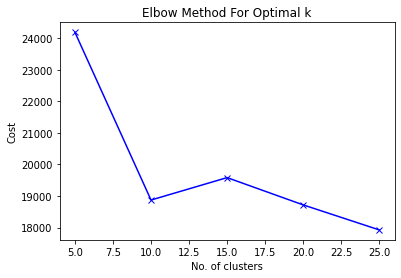

In [60]:
# Elbow curve to find optimal K
cost = []
K = range(5,30,5)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5, verbose=1)
    kmode.fit_predict(composition_ranking_df)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

In [61]:
# Building the model with 3 clusters
kmode = KModes(n_clusters=10, init = "random", n_init = 5, verbose=1)
clusters = kmode.fit_predict(composition_ranking_df)
clusters

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 23874.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 1579, cost: 23978.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 1692, cost: 20902.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 1860, cost: 22683.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 151, cost: 22529.0
Best run was number 3


array([4, 4, 4, ..., 0, 0, 0], dtype=uint16)

In [64]:
kmode_ranking_df = composition_ranking_df.copy()
kmode_ranking_df.insert(0, "group", clusters, True)

In [65]:
kmode_ranking_df

,group,comp,value_count,average_placement
0,4,"Jae-Drr-Swt-Ashe,Rag-Car-Hecarim,Jae-Shr-Neeko,Rag-Brr-War-Shen,Rag-Shr-Drn-Shyvana,Jae-Str-Soraka,Rag-Swt-Xayah,Mie-Drr-War-Yasuo",1,1.0
1,4,"Gud-Myc-Bad-Bard,Mie-Drn-DragonBlue,Rag-Car-Hecarim,Trr-Mae-Heimerdinger,Trr-Myc-Evr-Lulu,Mie-Car-Nunu,Gud-Car-Sejuani,-TrainerDragon",1,1.0
2,4,"Gud-Myc-Bad-Bard,Tet-Drr-LeeSin,Tet-Brr-Led-Ornn,Rag-Drr-Sett,Rag-Brr-War-Shen,Rag-Shr-Drn-Shyvana,Rag-Drr-Shr-Swain,Mie-Drr-War-Yasuo",1,1.0
3,4,"Jae-Evr-Led-Anivia,Scn-Asn-Diana,Tet-Drr-LeeSin,Jae-Shr-Neeko,Mie-Car-Nunu,Whs-Mae-Brr-Sylas,She-Drr-Led-Volibear,Rag-Swt-Xayah",1,1.0
4,4,"Tet-Drn-AoShin,Gud-Myc-Bad-Bard,Jae-Shr-Gnar,Trr-Myc-Evr-Lulu,Jae-Shr-Neeko,Tet-Brr-Led-Ornn,Rel-Evr-Sona,Jae-Str-Soraka",2,1.0
...,...,...,...,...
14643,0,"Jae-Drr-Swt-Ashe,Jae-Shr-Gnar,Jae-Drr-Karma,Tet-Drr-LeeSin,Rag-Drr-Sett,Rag-Brr-War-Shen,Rag-Drr-Shr-Swain,She-Drr-Led-Volibear,Mie-Drr-War-Yasuo",1,8.0
14644,0,"She-Drn-Gun-DragonGold,Rag-Car-Hecarim,Rag-She-Asn-Kayn,Gud-Car-Sejuani,Gud-Swt-Twitch,Rag-Swt-Xayah,Mie-Drr-War-Yasuo,She-Spf-Mae-Zoe",1,8.0
14645,0,"She-Drn-Gun-DragonGold,Rag-Car-Hecarim,Rag-She-Asn-Kayn,Gud-Asn-Talon,She-Drr-Led-Volibear,Rag-Swt-Xayah,Mie-Drr-War-Yasuo",1,8.0
14646,0,"Jae-Drr-Swt-Ashe,Jae-Shr-Gnar,Jae-Drr-Karma,Tet-Drr-LeeSin,Jae-Shr-Neeko,Rag-Drr-Sett,Rag-Brr-War-Shen,Rag-Drr-Shr-Swain",1,8.0


In [66]:
kmode_ranking_df['grp_count'] = kmode_ranking_df.groupby(['group'], as_index=False)['value_count'].transform('sum')
kmode_ranking_df['grp_placement'] = kmode_ranking_df.groupby(['group'], as_index=False)['average_placement'].transform('mean')

In [ ]:
top5_comp_ranking_list = []
m = comp_ranking_df[comp_ranking_df['grp_count']>=10] #[:5] #Top 5 with counts >= 12
top5_comp_ranking_list.extend(m.values)
top_comp_ranking_df = pd.DataFrame(top5_comp_ranking_list, columns=['comp', 'value_count', 'average_placement', 'group', 'grp_count', 'grp_placement'])

In [71]:
kmode_ranking_df['comp'] = kmode_ranking_df['comp'].apply(remove_traits)
kmode_ranking_df['mode'] = kmode_ranking_df.groupby('group')['comp'].transform(lambda x: pd.Series.mode(x)[0])
kmode_ranking_df.groupby(['group']).head(1).sort_values(by='grp_placement')

,group,comp,value_count,average_placement,grp_count,grp_placement,mode
0,4,"Ashe, Hecarim, Neeko, Shen, Shyvana, Soraka, Xayah, Yasuo",1,1.000000,1564,1.000000,"Aatrox, Ashe, DragonGold, Kayn, Shen, Volibear, Xayah, Zoe"
3531,6,"Corki, Hecarim, Illaoi, Lulu, Neeko, Xayah",1,3.000000,1798,3.000000,"Aatrox, Anivia, Ashe, DragonGold, Soraka, Volibear, Yasuo, Zoe"
4170,8,"Hecarim, Ornn, Pyke, Shen, Talon, Thresh, Twitch, Xayah",1,3.000000,1,3.000000,"Hecarim, Ornn, Pyke, Shen, Talon, Thresh, Twitch, Xayah"
5277,9,"Heimerdinger, Jinx, Lulu, Senna, Sett, Sona, TrainerDragon, Tristana",1,4.000000,1702,4.000000,"Aatrox, Anivia, DragonGold, Kayn, Ornn, Sett, Swain, Volibear"
1450,7,"Bard, DragonBlue, Hecarim, Nunu, Sejuani, Soraka, Twitch, Yasuo",3,1.333333,1302,4.163882,"Aatrox, Bard, DragonGold, Kayn, Thresh, Volibear, Yasuo, Zoe"
7099,1,"Ashe, Bard, Hecarim, Karma, LeeSin, Neeko, Ornn, Sett, Swain, Yasuo",1,5.000000,2011,5.000000,"Aatrox, Anivia, DragonGreen, Gnar, Karma, Neeko, Taric"
1447,0,"Ashe, Karma, LeeSin, Neeko, Ornn, Sett, Swain, Xayah, Yasuo",4,1.250000,18629,5.082293,
8932,5,"DragonBlue, Hecarim, Leona, Lulu, Nunu, Thresh, Yasuo",1,6.000000,1973,6.000000,"Aatrox, Anivia, Corki, DragonGold, Kayn, Sona, Volibear, Zoe"
10826,2,"Ashe, DragonPurple, Elise, Neeko, Shen, Sylas, Yasuo",1,7.000000,1867,7.000000,"Aatrox, Anivia, AoShin, Ornn, Sylas, Volibear, Zoe"
11654,3,"DragonPurple, Gnar, Lulu, Neeko, Soraka, Talon",1,7.000000,1,7.000000,"DragonPurple, Gnar, Lulu, Neeko, Soraka, Talon"


In [78]:
def get_unit_composition(df: matches_df):
    # filter and melt the dataframe
    df = df.filter(['placement']+units_col+traits_col)
    return df.sort_values(by='placement')

In [79]:
units_comp_df:DataFrame = get_unit_composition(matches_df)

In [80]:
units_comp_df

,placement,TFT7_Aatrox,TFT7_Anivia,TFT7_AoShin,TFT7_Ashe,TFT7_AurelionSol,TFT7_Bard,TFT7_Braum,TFT7_Corki,TFT7_Diana,...,Set7_Scalescorn,Set7_Shapeshifter,Set7_Shimmerscale,Set7_SpellThief,Set7_Starcaller,Set7_Swiftshot,Set7_Tempest,Set7_Trainer,Set7_Warrior,Set7_Whispers
22282,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
19431,1,0,0,0,0,2,2,0,0,0,...,0,0,0,1,1,0,0,0,0,0
26376,1,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
9139,1,0,0,0,2,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
3573,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25870,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
17770,8,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,2
3989,8,0,0,0,0,0,1,0,0,0,...,0,0,0,1,1,0,1,0,0,2
17754,8,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [82]:
units_composition_df = units_comp_df.copy()

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 14601, cost: 363804.0
Run 1, iteration: 2/100, moves: 4677, cost: 357928.0
Run 1, iteration: 3/100, moves: 748, cost: 357432.0
Run 1, iteration: 4/100, moves: 614, cost: 357432.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 7984, cost: 345127.0
Run 2, iteration: 2/100, moves: 2270, cost: 344831.0
Run 2, iteration: 3/100, moves: 592, cost: 344719.0
Run 2, iteration: 4/100, moves: 616, cost: 344454.0
Run 2, iteration: 5/100, moves: 104, cost: 344454.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 7742, cost: 350690.0
Run 3, iteration: 2/100, moves: 5036, cost: 344911.0
Run 3, iteration: 3/100, moves: 1138, cost: 344911.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 10090, cost: 340

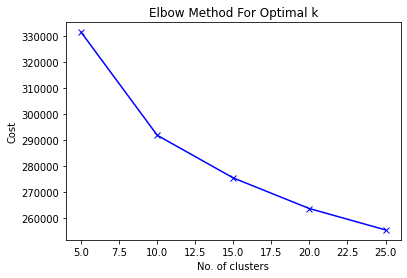

In [83]:
# Elbow curve to find optimal K
cost = []
K = range(5,50,10)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5, verbose=1)
    kmode.fit_predict(units_composition_df)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

In [143]:
# Building the model with 3 clusters
kmode = KModes(n_clusters=25, init = "random", n_init = 5, verbose=1)
clusters = kmode.fit_predict(units_composition_df)
clusters

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 9254, cost: 258361.0
Run 1, iteration: 2/100, moves: 3292, cost: 256990.0
Run 1, iteration: 3/100, moves: 1010, cost: 256235.0
Run 1, iteration: 4/100, moves: 895, cost: 255900.0
Run 1, iteration: 5/100, moves: 3, cost: 255900.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 11937, cost: 263604.0
Run 2, iteration: 2/100, moves: 3447, cost: 262588.0
Run 2, iteration: 3/100, moves: 584, cost: 262588.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 12986, cost: 260907.0
Run 3, iteration: 2/100, moves: 3519, cost: 258551.0
Run 3, iteration: 3/100, moves: 861, cost: 257581.0
Run 3, iteration: 4/100, moves: 970, cost: 257478.0
Run 3, iteration: 5/100, moves: 111, cost: 257410.0
Run 3, iteration: 6/100, moves: 51, cost: 257410.0
Init: initializing centroi

array([22, 16,  2, ..., 16,  0,  1], dtype=uint16)

In [144]:
kmode_ranking_df = units_composition_df.copy()
kmode_ranking_df.insert(0, "group", clusters, True)

In [145]:
kmode_ranking_df

,group,placement,TFT7_Aatrox,TFT7_Anivia,TFT7_AoShin,TFT7_Ashe,TFT7_AurelionSol,TFT7_Bard,TFT7_Braum,TFT7_Corki,...,Set7_Scalescorn,Set7_Shapeshifter,Set7_Shimmerscale,Set7_SpellThief,Set7_Starcaller,Set7_Swiftshot,Set7_Tempest,Set7_Trainer,Set7_Warrior,Set7_Whispers
22282,22,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
19431,16,1,0,0,0,0,2,2,0,0,...,0,0,0,1,1,0,0,0,0,0
26376,2,1,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
9139,5,1,0,0,0,2,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
3573,21,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25870,6,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
17770,24,8,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,2
3989,16,8,0,0,0,0,0,1,0,0,...,0,0,0,1,1,0,1,0,0,2
17754,0,8,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [146]:
def get_unit_composition_ranking(df: DataFrame, add_trait=True):
    # filter and melt the dataframe
    df = df.filter(['placement', 'group']+units_col)
    # join units lvl > 0 to 1 column
    df['comp'] = df[units_col].apply(lambda row: ', '.join(
        row[row > 0].index.values.astype(str)), axis=1)

    if add_trait:
        df['comp'] = df['comp'].apply(add_traits)

    df['comp'] = df['comp'].str.replace('TFT7_', '')
    df = df.filter(['placement', 'group', 'comp'])
    return df.sort_values(by='group')

In [147]:
kmode_ranking_df = get_unit_composition_ranking(kmode_ranking_df, add_trait=False)

In [148]:
kmode_ranking_df

,placement,group,comp
8174,4,0,"Braum, Leona, Shen, Yone"
15482,5,0,"AoShin, Lulu, Ornn, Ryze, Shen, Sylas"
12218,5,0,"DragonBlue, Leona, Nunu, Olaf, Shen, Thresh, Yone"
1628,1,0,"Corki, Hecarim, Neeko, Ornn, Pyke, Volibear, Xayah, Yasuo"
12205,5,0,"Elise, Neeko, Ornn, Sylas"
...,...,...,...
19340,4,24,"Corki, DragonPurple, Jinx, Ornn, Sona, Sylas, Yasuo"
19815,6,24,"DragonPurple, Lulu, Nami, Ornn, Shen, Sylas, Zoe"
23499,6,24,"DragonPurple, Illaoi, LeeSin, Olaf, Ornn, Shen, Sylas"
8917,6,24,"DragonPurple, Illaoi, Ornn, Pyke, Shen, Skarner, Sylas"


In [149]:
kmode_ranking_df['grp_count'] = kmode_ranking_df.groupby(['group'], as_index=False)['group'].transform('count')
kmode_ranking_df['grp_placement'] = kmode_ranking_df.groupby(['group'], as_index=False)['placement'].transform('mean')

In [ ]:
top5_comp_ranking_list = []
m = kmode_ranking_df[kmode_ranking_df['grp_count']>=10] #[:5] #Top 5 with counts >= 12
top5_comp_ranking_list.extend(m.values)
top_kmode_ranking_df = pd.DataFrame(top5_comp_ranking_list, columns=['comp', 'value_count', 'average_placement', 'group', 'grp_count', 'grp_placement'])

In [150]:
kmode_ranking_df['mode'] = kmode_ranking_df.groupby('group')['comp'].transform(lambda x: pd.Series.mode(x)[0])
kmode_ranking_df.groupby(['group']).head(1).sort_values(by='grp_placement')

,placement,group,comp,grp_count,grp_placement,mode
3334,1,19,"Bard, Diana, DragonGreen, Pyke, Qiyana, Soraka, Talon, Yasuo",1269,3.362490,"Bard, DragonGreen, Gnar, Neeko, Pyke, Soraka, Talon, Yasuo"
17945,1,11,"Bard, DragonPurple, Heimerdinger, Lulu, Nami, Sona, Sylas, TrainerDragon",534,3.423221,"Bard, DragonPurple, Heimerdinger, Lulu, Sona, Sylas, TrainerDragon, Zoe"
3754,8,22,"Bard, DragonBlue, Hecarim, Nunu, Sejuani, Yasuo, Yone",716,3.491620,"Bard, DragonBlue, Hecarim, Nunu, Sejuani, Yasuo, Yone"
29148,2,1,"Anivia, Bard, DragonGreen, Gnar, Lulu, Neeko, Soraka",1240,3.587903,"Anivia, Bard, DragonGreen, Gnar, Lulu, Neeko, Yasuo"
11570,8,16,"Bard, DragonPurple, Lulu, Nami, Sylas, Yasuo, Zoe",866,3.663972,"DragonPurple, Illaoi, Skarner, Sylas, Twitch, Varus"
3806,4,7,"Corki, DragonGold, Lulu, Sona, Talon, Thresh, TrainerDragon, Tristana",1508,3.919761,"Bard, Braum, Corki, DragonGold, Lulu, Sona, TrainerDragon, Tristana"
23205,1,4,"DragonPurple, Ornn, Pyke, Qiyana, Shen, Sylas, Thresh, Yasuo",2962,4.095206,"DragonPurple, Ornn, Pyke, Qiyana, Shen, Sylas, Thresh"
30389,2,12,"Heimerdinger, Illaoi, Lulu, Nami, Pyke, Sylas, TrainerDragon, Twitch, Varus",217,4.271889,"Heimerdinger, Illaoi, Lulu, Nami, Sona, Sylas, TrainerDragon, Twitch, Varus"
33,2,20,"Bard, Corki, DragonPurple, Hecarim, Lulu, Sejuani, Sona, TahmKench, TrainerDragon, Tristana",375,4.314667,"Bard, Corki, DragonPurple, Lulu, Ornn, Sona, TrainerDragon, Tristana"
28808,5,6,"Hecarim, Illaoi, Ornn, Qiyana, Sejuani, Talon, Twitch, Varus, Yasuo",3658,4.344997,"Hecarim, Ornn, Qiyana, Sejuani, Shen, Talon, Twitch, Xayah"
